# Importing Header files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import h5py
import os

/home/mohit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Part I

## Reading Dataset 

In [123]:
# Loading the dataset
os.getcwd()

# training label:
train_dataset = h5py.File('trainCats.h5', "r")
trainSetX = np.array(train_dataset["train_set_x"][:]) # your train set features
trainSetY = np.array(train_dataset["train_set_y"][:]) # your train set labels

# Reading the test data and test labels:
test_dataset = h5py.File('testCats.h5', "r")
testSetX = np.array(test_dataset["test_set_x"][:]) # your test set features
testSetY = np.array(test_dataset["test_set_y"][:]) # your test set labels

## Flattening of Data 

In [124]:

# To check the shape of the input data and convert in desired shape:
trainSetY = trainSetY.reshape((1, trainSetY.shape[0]))
testSetY = testSetY.reshape((1, testSetY.shape[0]))

num_var = trainSetX.shape[1]*trainSetX.shape[2]*trainSetX.shape[3]
trainSetX_new = np.zeros((trainSetX.shape[0],num_var)).T
for i in range(trainSetX.shape[0]):
    trainSetX_new[:, i] = trainSetX[i].reshape(-1)

testSetX_new = np.zeros((testSetX.shape[0],num_var)).T

for i in range(testSetX.shape[0]):
    testSetX_new[:, i] = testSetX[i].reshape(-1)
    

## To try different normalization

In [116]:
## Calling different normalization function

#testSetX_new = normalize255(testSetX_new)
#trainSetX_new = normalize255(trainSetX_new)

#testSetX_new = normalizeL1(testSetX_new)
#trainSetX_new = normalizeL1(trainSetX_new)

testSetX_new = normalizeL2(testSetX_new)
trainSetX_new = normalizeL2(trainSetX_new)

## Normalization

In [29]:
# Defining normalization function

def normalize255(X):
    X_new = X/255
    
    return X_new

def normalizeL1(X):
    X_normalized = preprocessing.normalize(X, norm='l1')
    
    return X_normalized

def normalizeL2(X):
    X_normalized = preprocessing.normalize(X, norm='l2')
    
    return X_normalized

In [18]:
X_normalized

array([[0.00963518, 0.11108794, 0.04647557, ..., 0.08104886, 0.01246905,
        0.0045342 ],
       [0.01750657, 0.10842781, 0.0400957 , ..., 0.08753287, 0.01355348,
        0.01581239],
       [0.03287727, 0.11154788, 0.0399224 , ..., 0.09687053, 0.01350316,
        0.03111599],
       ...,
       [0.        , 0.05134795, 0.08641483, ..., 0.05322653, 0.00250478,
        0.        ],
       [0.        , 0.05055729, 0.08910722, ..., 0.06762037, 0.00315983,
        0.        ],
       [0.        , 0.05821654, 0.10205862, ..., 0.10708968, 0.        ,
        0.        ]])

## To know the classes of the dataset:

In [115]:
classes = np.array(test_dataset["list_classes"][:]) 

In [16]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [31]:
testSetX_new.shape

(12288, 50)

In [20]:
trainSetY.shape

(1, 209)

## Model

In [92]:
# Define sigmoid function:
def sigmoid(z):
    sig = 1/(1+np.exp(-(z)))
    return sig

# Calculating cross entropy
def propagate(w, b, SetX, SetY):
    m = SetX.shape[1]
    A = sigmoid(np.dot(w.T,SetX)+b)
    L = -1/m * np.sum(SetY*np.log(A)+(1-SetY)*np.log(1-A))
    dw = (1/m) * (np.dot(SetX,(A-SetY).T))
    db = (1/m) * (np.sum(A-SetY))
    
    # Removes the extra dimension:
    L = np.squeeze(L)
    
    # Creating a dictionary in python
    # https://www.pythonforbeginners.com/dictionary/how-to-use-dictionaries-in-python/
    grads = {"dw": dw, "db": db}
    
    return grads, L

# To find optimal w and b
def converge(SetX, SetY, w, b, num_iter, learning_rate):
    costs = []
    for i in range(num_iter):
        grads, L = propagate(w, b, SetX, SetY)
        dw = grads["dw"]
        db = grads["db"]
        w = w-learning_rate*dw
        b = b-learning_rate*db
        costs.append(L)

    params = {"w":w, "b":b}
    grads = {"dw":dw, "db":db}
    
    return params, grads, costs

def predict(w, b, SetX):
    m = SetX.shape[1]
    predict_Y = np.zeros((1, m))
    w = w.reshape(SetX.shape[0], 1)
    A = sigmoid( np.dot(w.T, SetX) + b)
    for i in range(A.shape[1]):
        if A[0,i] <= 0.5:
            predict_Y[0,i] = 0
        else:
            predict_Y[0,i] = 1
            
    return predict_Y

# Creating the model:
def model(trainSetX, trainSetY, testSetX, testSetY, num_iterations, learning_rate):
    
    #Initialize paramters with 0
    w = np.zeros((trainSetX.shape[0],1))
    b = 0
    
    # Gradient Descent
    params, grads, costs = converge(trainSetX, trainSetY, w, b, num_iterations, learning_rate)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = params["w"]
    b = params["b"]
    
    #Predict test/train set examples
    predict_testSetY = predict(w,b,testSetX)
    predict_trainSetY = predict(w,b,trainSetX)
    
    final = {"costs": costs, "predict_testSetY": predict_testSetY, "predict_trainSetY": predict_trainSetY,
         "b": b, "w": w, "num_iterations": num_iterations, "learning_rate": learning_rate}
    
    #Print train/test errors
    print("Accuracy for training set is: {} %".format(100-np.mean(np.abs(predict_trainSetY-trainSetY))*100))
    print("Accuracy for testing set is: {} %".format(100-np.mean(np.abs(predict_testSetY-testSetY))*100))
    
    return final


# https://mashimo.wordpress.com/2017/10/19/cat-or-not-cat/
# http://dataaspirant.com/2017/04/15/implement-logistic-regression-model-python-binary-classification/

## To run the code

In [112]:
# To run the code:
d = model(trainSetX_new, trainSetY, testSetX_new, testSetY, num_iterations=20000, learning_rate=0.035)

Accuracy for training set is: 99.52153110047847 %
Accuracy for testing set is: 56.0 %


## Plot the graph

<IPython.core.display.Javascript object>


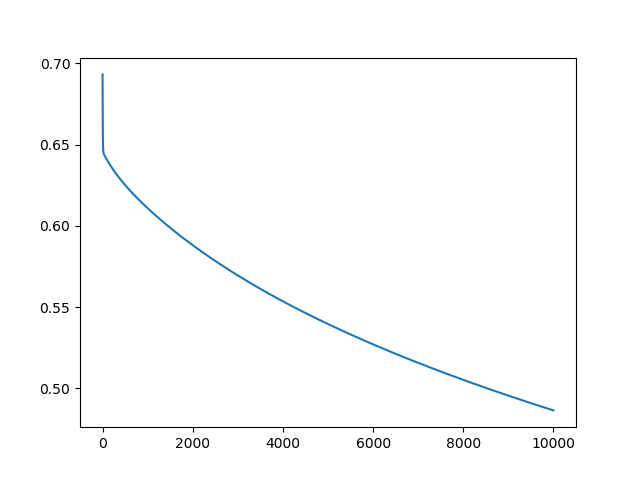

In [113]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(len(model_param['costs'])), model_param['costs'])
plt.savefig("fooT403520000.png")
#plt.plot(d['costs'])

In [88]:
(model_param['costs'])

[0.6931471805599453,
 0.6831676038874825,
 0.6752959947589372,
 0.6690805913573413,
 0.6641655803808006,
 0.6602717702645589,
 0.6571805175221267,
 0.6547207084177625,
 0.6527583942820936,
 0.6511886297173946,
 0.6499290892245949,
 0.6489150944547224,
 0.6480957479289992,
 0.6474309287144043,
 0.6468889569372851,
 0.6464447762956451,
 0.6460785375506853,
 0.6457744925655421,
 0.6455201291342895,
 0.6453054928154647,
 0.6451226542755717,
 0.6449652900904014,
 0.6448283522032922,
 0.6447078068114807,
 0.6446004277390488,
 0.6445036326597123,
 0.6444153530854384,
 0.6443339310132847,
 0.6442580366567457,
 0.6441866028812856,
 0.6441187728944848,
 0.6440538584688856,
 0.643991306545829,
 0.6439306725163882,
 0.6438715988279667,
 0.6438137978430681,
 0.6437570380963626,
 0.6437011332699956,
 0.6436459333448883,
 0.643591317495208,
 0.6435371883801799,
 0.6434834675566888,
 0.6434300917913307,
 0.643377010094635,
 0.6433241813353741,
 0.6432715723210132,
 0.6432191562528723,
 0.6431669114825

# II: Using inbuild function

In [117]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0, max_iter = 100)
lr.fit(trainSetX_new.T, trainSetY.T.ravel())

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [70]:
lr

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## For confusion matrix 

In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainSetY.T.ravel(), lr.predict(trainSetX_new.T))

array([[137,   0],
       [  0,  72]])

In [75]:
lr.coef_.shape

(1, 12288)

In [76]:
lr.coef_

array([[ 0.05670354, -0.11384905, -0.04205973, ..., -0.06593732,
        -0.11237646,  0.15406249]])

In [77]:
lr.intercept_

array([-0.00129565])

## For Prediction 

In [120]:
Y_prediction = lr.predict(testSetX_new.T)
Y_prediction.shape

(50,)

In [121]:
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - testSetY)) * 100))

test accuracy: 56.0 %


In [122]:
confusion_matrix(testSetY.T.ravel(), lr.predict(testSetX_new.T))

array([[13,  4],
       [18, 15]])